In [ ]:
# Import libraries
import yfinance as yf
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the data
stock_name = yf.download('MDLZ', start='2010-01-01', end='2024-12-31')

# Summarize the dataset
stock_name.shape

[*********************100%%**********************]  1 of 1 completed


(3634, 6)

In [ ]:
stock_name.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3634 entries, 2010-01-04 to 2024-06-11
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3634 non-null   float64
 1   High       3634 non-null   float64
 2   Low        3634 non-null   float64
 3   Close      3634 non-null   float64
 4   Adj Close  3634 non-null   float64
 5   Volume     3634 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 198.7 KB


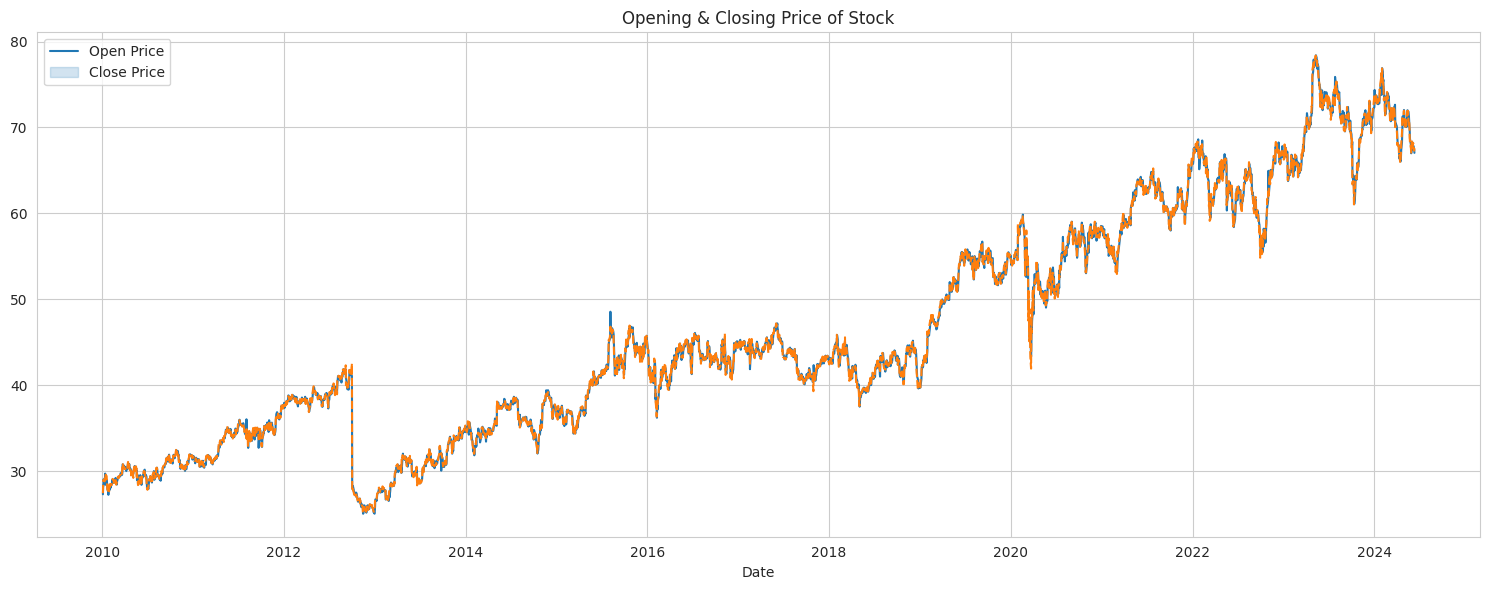

In [ ]:
# Visualize Data with Seaborn
# Opening & Closing Price Plot
plt.figure(figsize=(15, 6))
sns.lineplot(data=stock_name[['Open', 'Close']])
plt.title("Opening & Closing Price of Stock")
plt.legend(['Open Price', 'Close Price'])
plt.tight_layout()
plt.show()

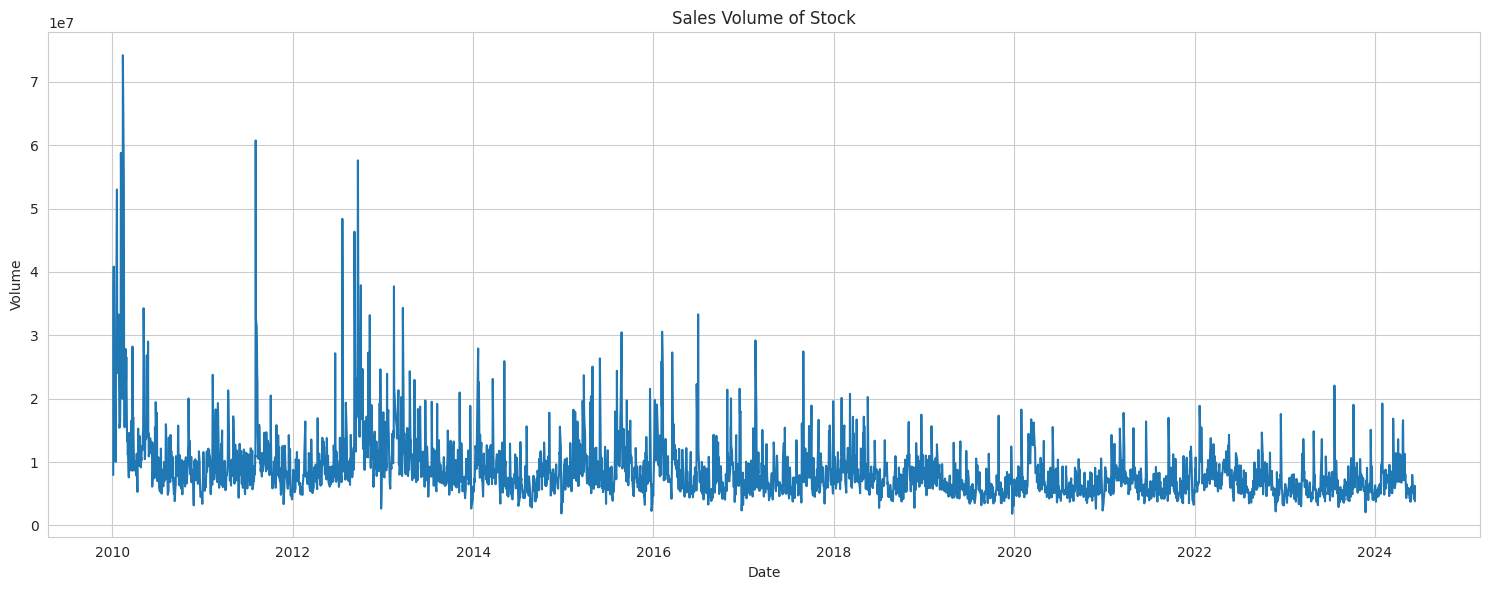

In [ ]:
# Sales Volume Plot
plt.figure(figsize=(15, 6))
sns.lineplot(data=stock_name, x=stock_name.index, y='Volume')
plt.title("Sales Volume of Stock")
plt.tight_layout()
plt.show()

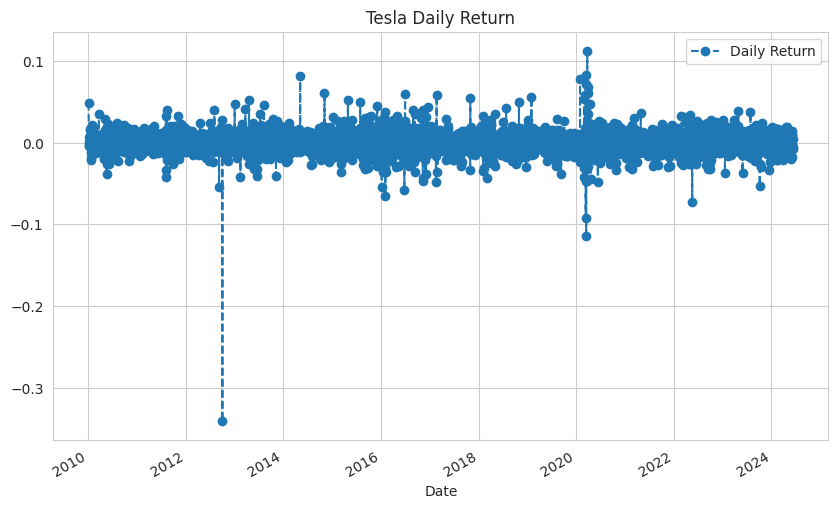

In [ ]:
# Calculate daily return percentage
stock_name['Daily Return'] = stock_name['Close'].pct_change().dropna()

# Create a single subplot
plt.figure(figsize=(10, 6))

# Plot the daily return percentage of Tesla
stock_name['Daily Return'].plot(legend=True, linestyle='--', marker='o')
plt.title('Stock Daily Return')

# Show plot
plt.show()

In [ ]:
stock_name.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Return
Date,,,,,,,
2010-01-04,27.299999,27.480000,27.170000,27.430000,13.157019,7953300,NaN
2010-01-05,28.320000,28.809999,28.010000,28.770000,13.799756,37152800,0.048852
2010-01-06,28.299999,29.160000,28.100000,28.969999,13.895689,40848800,0.006952
2010-01-07,29.049999,29.090000,28.570000,28.900000,13.862113,18359900,-0.002416
2010-01-08,28.760000,28.940001,28.530001,28.930000,13.876507,11000000,0.001038


In [ ]:
# Data cleaning
# Remove unnecessary columns (e.g., Adj Close)
del stock_name["Adj Close"]

In [ ]:
# Create target variables
# Add a 'Tomorrow' column with the closing price shifted by one day
stock_name["Tomorrow"] = stock_name["Close"].shift(-1)


In [ ]:
# Add a binary 'Target' column indicating if the stock price increased the next day
stock_name["Target"] = (stock_name["Tomorrow"] > stock_name["Close"]).astype(int)

In [ ]:
stock_name.head()

,Open,High,Low,Close,Volume,Daily Return,Tomorrow
Date,,,,,,,
2010-01-04,27.299999,27.480000,27.170000,27.430000,7953300,NaN,28.770000
2010-01-05,28.320000,28.809999,28.010000,28.770000,37152800,0.048852,28.969999
2010-01-06,28.299999,29.160000,28.100000,28.969999,40848800,0.006952,28.900000
2010-01-07,29.049999,29.090000,28.570000,28.900000,18359900,-0.002416,28.930000
2010-01-08,28.760000,28.940001,28.530001,28.930000,11000000,0.001038,28.799999


In [ ]:
# Initialize the machine learning model
# Use a RandomForestClassifier for the prediction model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

In [ ]:
# Split the data into training and testing sets
# Use the last 100 rows for testing and the rest for training
train = stock_name.iloc[:-100]
test = stock_name.iloc[-100:]

In [ ]:
# Define the predictors/features
# Use relevant features such as 'Close', 'Volume', 'Open', 'High', and 'Low'
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [ ]:
# Train the model
# Fit the model using the training data
model.fit(train[predictors], train["Target"])


RandomForestClassifier(min_samples_split=100, random_state=1)

In [ ]:
# Make predictions
# Predict on the test data and calculate the precision score
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

precision = precision_score(test["Target"], preds)
print("Precision Score:", precision)

Precision Score: 0.5


<Axes: xlabel='Date'>

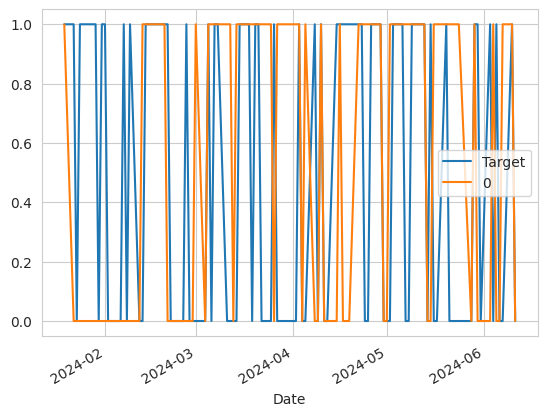

In [ ]:
# Plot the actual vs predicted values
    # Combine the actual and predicted values for comparison and plot them
combined = pd.concat([test["Target"], preds], axis=1)
    # combined.columns = ["Actual", "Predicted"]
combined.plot()

In [ ]:
# Define a function to make predictions
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
# Define a function for backtesting
# Test the model on different slices of the data
def backtest(data, model, predictors, start=1, step=100):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)  # Ensure predict function generates predictions
        all_predictions.append(predictions)

    return pd.concat(all_predictions) if all_predictions else pd.DataFrame()  # Handle empty list case

In [ ]:
# Perform backtesting
# Run the backtest function and analyze the results
predictions = backtest(stock_name, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

Predictions
0    2010
1    1623
Name: count, dtype: int64

In [ ]:
# Calculate the precision score of the backtested predictions
precision = precision_score(predictions["Target"], predictions["Predictions"])
print("Backtest Precision Score:", precision)


Backtest Precision Score: 0.5274183610597659


In [ ]:
# Calculate the precision score of the backtested predictions
print(predictions["Target"].value_counts() / predictions.shape[0])

Target
1    0.518029
0    0.481971
Name: count, dtype: float64


In [ ]:
# Adjusting horizons based on the size of the dataset
if len(stock_name) < 100:
    horizons = [2, 5, 10]
elif len(stock_name) < 500:
    horizons = [5, 20, 50]
else:
    horizons = [30, 100, 250]

# Perform feature engineering with adjusted horizons
new_predictors = []
for horizon in horizons:
    rolling_averages = stock_name.rolling(horizon).mean()
    ratio_column = f"Close_Ratio_{horizon}"
    stock_name[ratio_column] = stock_name["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    stock_name[trend_column] = stock_name.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column, trend_column]

In [ ]:
# Remove rows with NaN values
stock_name = stock_name.dropna(subset=stock_name.columns[stock_name.columns != "Tomorrow"])


In [ ]:
stock_name

,Open,High,Low,Close,Volume,Daily Return,Tomorrow,Target,Close_Ratio_30,Trend_30,Close_Ratio_100,Trend_100,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,
2010-12-30,31.340000,31.610001,31.309999,31.510000,4033200,-0.001584,31.510000,0,1.016364,17.0,1.019157,53.0,1.050733,134.0
2010-12-31,31.500000,31.629999,31.370001,31.510000,3398900,0.000000,31.670000,1,1.015251,16.0,1.018749,53.0,1.050349,133.0
2011-01-03,31.760000,31.760000,31.480000,31.670000,8525800,0.005078,31.600000,0,1.019366,16.0,1.023230,54.0,1.055302,133.0
2011-01-04,31.610001,31.750000,31.360001,31.600000,11578300,-0.002210,31.530001,0,1.015849,16.0,1.020276,54.0,1.052591,133.0
2011-01-05,31.459999,31.750000,31.459999,31.530001,10456100,-0.002215,31.270000,0,1.012535,15.0,1.017349,54.0,1.049896,132.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-05,67.860001,68.250000,67.129997,67.980003,5103000,-0.001615,68.190002,1,0.970667,13.0,0.954846,48.0,0.958347,127.0
2024-06-06,67.809998,68.779999,67.599998,68.190002,4769400,0.003089,67.809998,0,0.975113,13.0,0.958460,48.0,0.961573,127.0
2024-06-07,67.860001,68.389999,67.650002,67.809998,4189100,-0.005573,67.300003,0,0.971063,13.0,0.953794,48.0,0.956492,127.0


In [ ]:
# Initialize a new model with updated parameters
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [ ]:
# Update the predict function to use probability thresholding
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])  # Fit the model to the training data
    preds = model.predict(test[predictors])  # Generate class predictions
    preds = pd.Series(preds, index=test.index, name="Predictions")  # Convert predictions to a Series
    combined = pd.concat([test["Target"], preds], axis=1)  # Combine predictions with actual target values
    return combined

print(predictions)

            Target  Predictions
Date                           
2010-01-05       1            1
2010-01-06       0            1
2010-01-07       1            1
2010-01-08       0            1
2010-01-11       1            1
...            ...          ...
2024-06-05       1            0
2024-06-06       0            0
2024-06-07       0            0
2024-06-10       1            1
2024-06-11       0            0

[3633 rows x 2 columns]


In [ ]:
# Backtest the model with new predictors
predictions = backtest(stock_name, model, new_predictors)

# Ensure that 'Predictions' column is present
if 'Predictions' in predictions.columns:
    print(predictions["Predictions"].value_counts())
else:
    print("Error: 'Predictions' column is not present in the results.")


Predictions
1    1958
0    1425
Name: count, dtype: int64


In [ ]:
precision = precision_score(predictions["Target"], predictions["Predictions"])

print("Updated Backtest Precision Score:", precision)
print(predictions["Target"].value_counts() / predictions.shape[0])


Updated Backtest Precision Score: 0.5199182839632278
Target
1    0.516997
0    0.483003
Name: count, dtype: float64


In [ ]:
# Analyze the final predictions
predictions

,Target,Predictions
Date,,
2010-12-31,1,0
2011-01-03,0,0
2011-01-04,0,0
2011-01-05,0,0
2011-01-06,0,0
...,...,...
2024-06-05,1,1
2024-06-06,0,1
2024-06-07,0,1


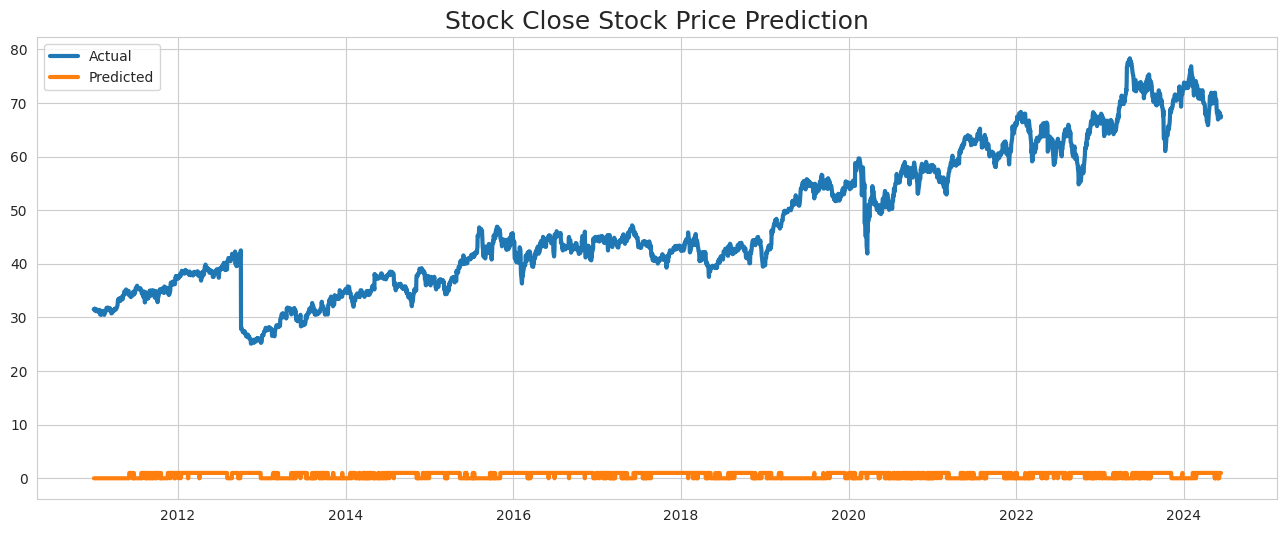

In [ ]:
# Visualize Predictions
plt.figure(figsize=(16, 6))
plt.title('Stock Close Stock Price Prediction', fontsize=18)
plt.plot(stock_name['Close'], label='Actual Closing Price', linewidth=3)
plt.plot(predictions.index, predictions['Predictions'], label='Predicted Movement', linewidth=3)
plt.legend(['Actual', 'Predicted'])
plt.show()

In [ ]:
stock_name.head()

,Open,High,Low,Close,Volume,Daily Return,Tomorrow,Target,Close_Ratio_30,Trend_30,Close_Ratio_100,Trend_100,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,
2010-12-30,31.340000,31.610001,31.309999,31.510000,4033200,-0.001584,31.510000,0,1.016364,17.0,1.019157,53.0,1.050733,134.0
2010-12-31,31.500000,31.629999,31.370001,31.510000,3398900,0.000000,31.670000,1,1.015251,16.0,1.018749,53.0,1.050349,133.0
2011-01-03,31.760000,31.760000,31.480000,31.670000,8525800,0.005078,31.600000,0,1.019366,16.0,1.023230,54.0,1.055302,133.0
2011-01-04,31.610001,31.750000,31.360001,31.600000,11578300,-0.002210,31.530001,0,1.015849,16.0,1.020276,54.0,1.052591,133.0
2011-01-05,31.459999,31.750000,31.459999,31.530001,10456100,-0.002215,31.270000,0,1.012535,15.0,1.017349,54.0,1.049896,132.0


## Acknowledgement:
I learned this code watching Youtube tutorial:

Predict The Stock Market With Machine Learning And Python: https://www.youtube.com/watch?v=1O_BenficgE&t=1265s
